In [1]:
import pytomography
from pytomography.io.SPECT import simind
import matplotlib.pyplot as plt
import torch

In a SPECT simulation, there are essentially two volumes of interest:
* The amount of the radioactive source at each point in space (referred to as the **source** in SIMIND)
* The attenuation coefficient at each point in space (referred to as the **phantom** in SIMIND)

The SPECT camera takes pictures of the **source** at different angles (it isn't able to directly access information about the **phantom**: this can only be obtained via a CT Scan)

In [2]:
projections = simind.get_projections('test_tot_w1.h00')
projections.shape

torch.Size([1, 3, 256, 256])

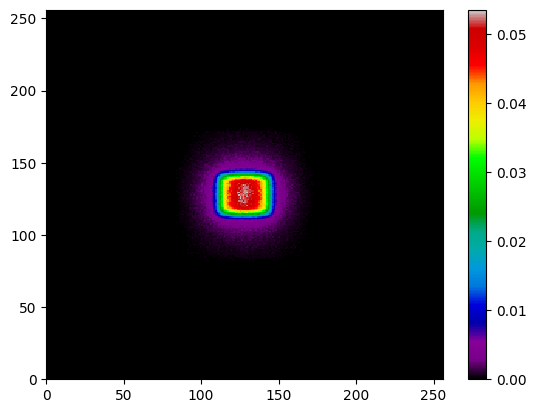

In [3]:
plt.pcolormesh(projections[0,0].cpu().T, cmap='nipy_spectral')
plt.colorbar()

Open projections and scatter

In [4]:
photopeak = simind.get_projections('test_tot_w1.h00')
scatter = simind.get_projections('test_sca_w1.h00')
primary = photopeak - scatter

Text(0.5, 1.0, 'Primary')

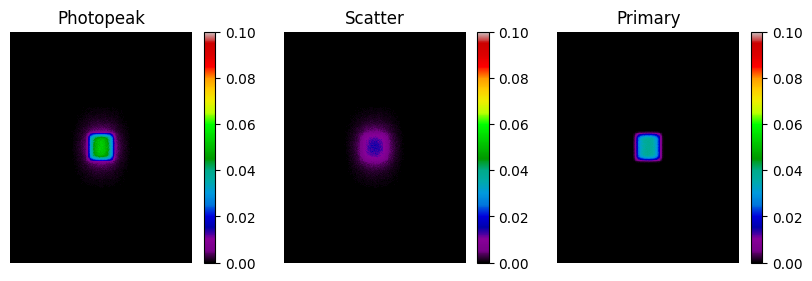

In [5]:
plt.subplots(1,3,figsize=(10,3))
plt.subplot(131)
plt.pcolormesh(photopeak[0,0].cpu().T, cmap='nipy_spectral', vmax=0.1)
plt.colorbar()
plt.axis('off')
plt.title('Photopeak')
plt.subplot(132)
plt.pcolormesh(scatter[0,0].cpu().T, cmap='nipy_spectral', vmax=0.1)
plt.colorbar()
plt.axis('off')
plt.title('Scatter')
plt.subplot(133)
plt.pcolormesh(primary[0,0].cpu().T, cmap='nipy_spectral', vmax=0.1)
plt.colorbar()
plt.axis('off')
plt.title('Primary')

# Discussion Of Units

Even if we change index 26 to simulate more photons, the values in the projection data don't increase. This naively doesn't make sense.

* Need to understand the units of the projections

**Real SPECT System Units**: Counts

**SIMIND Output Units**: Counts / second / MBq

In [6]:
activity = 10 #MBq
time = 15 #seconds per projection

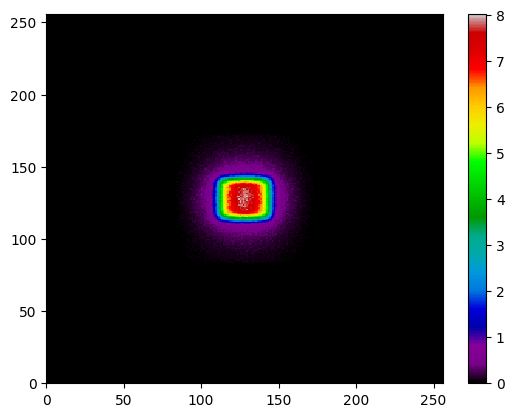

In [7]:
photopeak = simind.get_projections('test_tot_w1.h00')
photopeak *= activity * time
plt.pcolormesh(photopeak[0,0].cpu().T, cmap='nipy_spectral')
plt.colorbar()

But it's still not discrete counts! 

Recall that any *counting* experiment in a *fixed time interval* is related to the Poisson distribution. This is true of counting cars, calls per hour at a call center, number of arrivals at a restaraunt, etc.

A poisson random variable can be written as $g \sim \text{Poisson}(\bar{g})$ where $g$ is an integer but $\bar{g}$ (the mean of the distribution) can be any real number.

The results that SIMIND give you are $\bar{g}$ for every single detector pixel. To simulate a real scan, you have to take Poisson statistics:

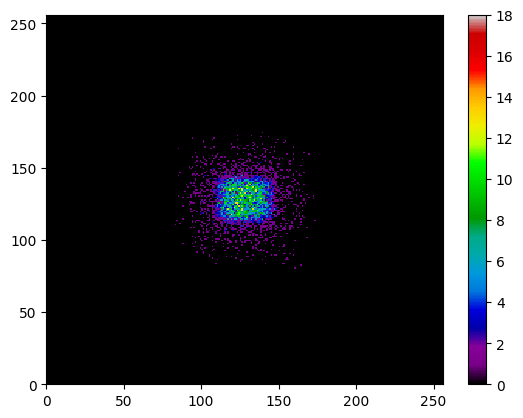

In [8]:
activity = 10 #MBq
time = 15 #seconds per projection
photopeak = simind.get_projections('test_tot_w1.h00')
photopeak = torch.poisson(photopeak * activity * time)
plt.pcolormesh(photopeak[0,0].cpu().T, cmap='nipy_spectral')
plt.colorbar()

The more activity, or the longer scan time you take, the more counts you get!